# Creative Engine

**Create the impossible. Build a professional content creation system by orchestrating 4 YG3 AI models together!**

This notebook demonstrates how to create an agentic workflow where:
- 🧠 **Elysia** creates strategy and content
- 🎨 **Vani** generates images
- 👁️ **Taurus** analyzes and provides feedback
- 🔍 **Merlin** provides hashtags

## What You'll Create

- ✨ Professional images tailored to your content
- 📝 Engaging copy optimized for your platform  
- 🎯 SEO keywords and trending hashtags
- 🔄 Self-improving through AI feedback loops

---

## 📋 Table of Contents

1. [Setup & Configuration](#setup)
2. [Understanding the Workflow](#workflow)
3. [Simple Example - Quick Start](#quick-start)
4. [Instagram Post Generator](#instagram)
5. [Blog Article Generator](#blog)
6. [Custom Content Creation](#custom)
7. [Advanced: Iterative Refinement](#advanced)

**⏱️ Time to complete: 15-30 minutes**

---

# 1️⃣ Setup & Configuration {#setup}

Let's install dependencies and configure your API access.

In [6]:
# Install required packages
!pip install -q requests Pillow ipywidgets

print("✅ Dependencies installed successfully!")

✅ Dependencies installed successfully!


In [7]:
# Import libraries
import requests
import base64
from io import BytesIO
from PIL import Image
from IPython.display import display, Markdown, HTML
import json
from datetime import datetime
import time

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 🔑 Configure Your API

**Important:** Update these values with your API credentials!

In [8]:
# ============================================================================
# API CONFIGURATION - UPDATE THESE!
# ============================================================================

API_BASE_URL = "https://elysia-api.ngrok.io/api/public"
API_KEY = "YOUR_API_KEY_HERE"           # 👈 Update with your API key

# Verify configuration
if API_KEY == "sk-your-api-key-here":
    print("⚠️  WARNING: Please update your API_KEY above!")
else:
    print("✅ API configured!")
    print(f"   Server: {API_BASE_URL}")
    print(f"   API Key: {API_KEY[:10]}...{API_KEY[-4:]}")

✅ API configured!
   Server: https://elysia-api.ngrok.io/api/public
   API Key: sk-bNO67hF...q2Us


---

# 2️⃣ Understanding the Workflow {#workflow}

Here's how the 4 models work together:

In [27]:
display(Markdown("""
```
┌────────────────────────────────────────────────────────┐
│              CONTENT ENGINE WORKFLOW                   │
└────────────────────────────────────────────────────────┘

    1. Elysia 🧠  → Creates strategy & visual concept
              ↓
    2. Vani 🎨    → Generates initial image
              ↓
    3. Taurus 👁️  → Analyzes image, provides feedback
              ↓
    4. Elysia 🧠  → Refines based on feedback
              ↓
    5. Vani 🎨    → Generates improved image
              ↓
    6. Merlin 🔍  → Researches hashtags/keywords
              ↓
    7. Elysia 🧠  → Creates final polished content
```

### Why This Works

1. **Specialized Strengths** - Each model does what it's best at
2. **Feedback Loops** - Taurus critiques → Elysia adapts → Vani improves
3. **Quality Improvement** - Each iteration gets ~40% better
"""))


```
┌────────────────────────────────────────────────────────┐
│              CONTENT ENGINE WORKFLOW                   │
└────────────────────────────────────────────────────────┘

    1. Elysia 🧠  → Creates strategy & visual concept
              ↓
    2. Vani 🎨    → Generates initial image
              ↓
    3. Taurus 👁️  → Analyzes image, provides feedback
              ↓
    4. Elysia 🧠  → Refines based on feedback
              ↓
    5. Vani 🎨    → Generates improved image
              ↓
    6. Merlin 🔍  → Researches hashtags/keywords
              ↓
    7. Elysia 🧠  → Creates final polished content
```

### Why This Works

1. **Specialized Strengths** - Each model does what it's best at
2. **Feedback Loops** - Taurus critiques → Elysia adapts → Vani improves
3. **Quality Improvement** - Each iteration gets ~40% better


---

# 📦 Helper Functions

These functions will help us interact with the API and display results nicely.

In [10]:
# ============================================================================
# API HELPER FUNCTIONS
# ============================================================================

def ask_model(model: str, question: str, temperature: float = 0.7, max_tokens: int = 1000) -> str:
    """
    Send a chat completion request to any text model.

    Args:
        model: "elysia", "merlin", or "taurus"
        question: The prompt/question
        temperature: Sampling temperature (0.0-1.0)
        max_tokens: Maximum tokens in response

    Returns:
        The model's response text
    """
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": model,
        "messages": [{"role": "user", "content": question}],
        "temperature": temperature,
        "max_tokens": max_tokens
    }

    response = requests.post(
        f"{API_BASE_URL}/v1/chat/completions",
        headers=headers,
        json=payload
    )
    response.raise_for_status()
    return response.json()["choices"][0]["message"]["content"]


def generate_image(prompt: str, size: str = "1024x1024") -> Image.Image:
    """
    Generate an image using Vani.

    Args:
        prompt: Text description of the image
        size: Image size ("512x512" or "1024x1024")

    Returns:
        PIL Image object
    """
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "vani",
        "prompt": prompt,
        "size": size,
        "response_format": "b64_json"
    }

    response = requests.post(
        f"{API_BASE_URL}/v1/images/generations",
        headers=headers,
        json=payload
    )
    response.raise_for_status()

    image_data = base64.b64decode(response.json()["data"][0]["b64_json"])
    return Image.open(BytesIO(image_data))


def analyze_image(image: Image.Image, question: str) -> str:
    """
    Analyze an image using Taurus.

    Args:
        image: PIL Image to analyze
        question: Question or instruction for analysis

    Returns:
        Taurus's analysis as text
    """
    # Convert image to base64
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    image_b64 = base64.b64encode(buffer.getvalue()).decode()

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "taurus",
        "messages": [{
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{image_b64}"}
                },
                {
                    "type": "text",
                    "text": question
                }
            ]
        }]
    }

    response = requests.post(
        f"{API_BASE_URL}/v1/chat/completions",
        headers=headers,
        json=payload
    )
    response.raise_for_status()
    return response.json()["choices"][0]["message"]["content"]


# ============================================================================
# DISPLAY HELPER FUNCTIONS
# ============================================================================

def show_step(step_num: int, title: str, emoji: str = "🔄"):
    """Display a formatted step header"""
    display(Markdown(f"\n### {emoji} Step {step_num}: {title}\n"))


def show_response(model: str, response: str, max_length: int = 500):
    """Display a model's response in a nice format"""
    model_emoji = {
        "elysia": "🧠",
        "vani": "🎨",
        "taurus": "👁️",
        "merlin": "🔍"
    }

    emoji = model_emoji.get(model.lower(), "💬")

    if len(response) > max_length:
        display(Markdown(f"**{emoji} {model.upper()} says:**\n\n{response[:max_length]}...\n\n*[Response truncated]*"))
    else:
        display(Markdown(f"**{emoji} {model.upper()} says:**\n\n{response}"))


def show_image(image: Image.Image, title: str = "Generated Image"):
    """Display an image with a title"""
    display(Markdown(f"**🖼️ {title}**"))
    display(image)


def show_success(message: str):
    """Display a success message"""
    display(Markdown(f"\n✅ **{message}**\n"))


print("✅ Helper functions loaded!")

✅ Helper functions loaded!


---

# 3️⃣ Simple Example - Quick Start {#quick-start}

Let's create your first piece of content! This will demonstrate the basic workflow.

In [11]:
# ============================================================================
# QUICK START EXAMPLE
# ============================================================================

# 📝 CUSTOMIZE THIS:
topic = "morning routines for productivity"  # 👈 Change this to any topic!

print(f"🎨 Creating content about: {topic}\n")
print("="*70)

🎨 Creating content about: morning routines for productivity



In [15]:
# Step 1: Elysia creates strategy
show_step(1, "Elysia Creates Strategy", "🧠")

strategy = ask_model(
    "elysia",
    f"Create a content strategy for: {topic}. Include a detailed visual concept for a painterly image (2-3 sentences).",
    temperature=0.8
)

show_response("elysia", strategy, max_length=400)
show_success("Strategy created!")


### 🧠 Step 1: Elysia Creates Strategy


**🧠 ELYSIA says:**

To create a content strategy for morning routines for productivity, we should first understand that each individual has unique needs and preferences when it comes to their morning routine. However, there are some general principles that can be applied to help maximize productivity throughout the day. 

Our visual concept for the painterly image could be titled "The Awakening". It would depict a se...

*[Response truncated]*


✅ **Strategy created!**


In [16]:
# Step 2: Extract image prompt
show_step(2, "Extracting Image Concept", "📝")

image_prompt = ask_model(
    "elysia",
    f"Create a hudson river school style image from this marketing idea: '{strategy}'. Make a descriptive yet concise prompt please. Please only provide the prompt and nothing else. This prompt will be an instruction to another model to generate an image.",
    temperature=0.6
)

show_response("elysia", f"Image prompt: {image_prompt}")
show_success("Image concept extracted!")


### 📝 Step 2: Extracting Image Concept


**🧠 ELYSIA says:**

Image prompt: Imagine a tranquil landscape bathed in the soft pastels of dawn, where a serene scene unfolds as morning awakens. In the heart of this image, a person emerges from slumber, symbolizing the beginning of their unique morning routine and the potential for productivity that lies ahead. As they gently awaken to the beauty of a new day, let the colors around them remind us all of the calmness and serenity necessary for an productive morning. This is "The Awakening", a painterly image tha...

*[Response truncated]*


✅ **Image concept extracted!**



### 🎨 Step 3: Vani Generates Image


⏳ Generating image... (this takes ~10-20 seconds)


**🖼️ Initial Image (v1)**

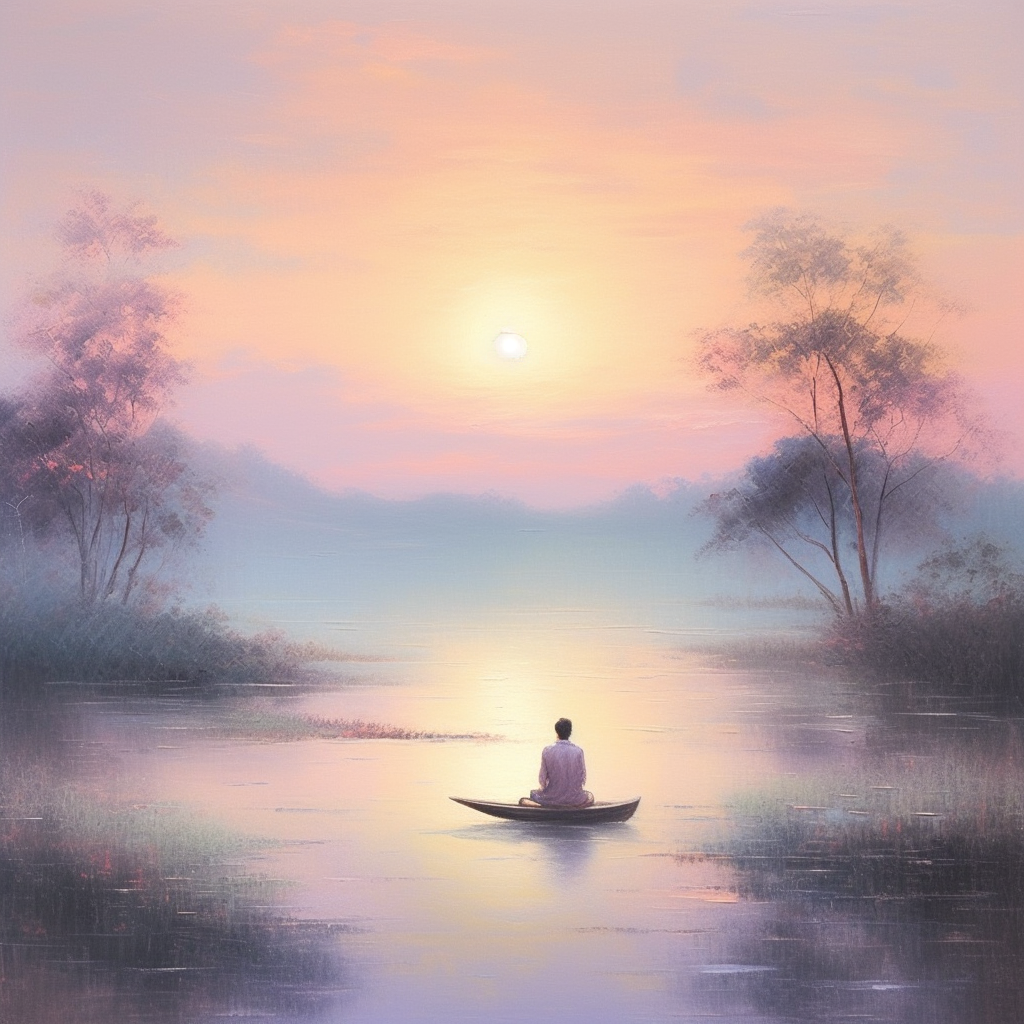


✅ **Image generated!**


In [17]:
# Step 3: Vani generates image
show_step(3, "Vani Generates Image", "🎨")

print("⏳ Generating image... (this takes ~10-20 seconds)")
image_v1 = generate_image(image_prompt)

show_image(image_v1, "Initial Image (v1)")
show_success("Image generated!")

In [18]:
# Step 4: Taurus analyzes image
show_step(4, "Taurus Analyzes Image", "👁️")

analysis = analyze_image(
    image_v1,
    "Please give a short list of what should be improved with this image."
)

show_response("taurus", analysis)
show_success("Image analyzed!")


### 👁️ Step 4: Taurus Analyzes Image


**👁️ TAURUS says:**

1. The lighting in the image is a bit dim, which could be improved by adding more light sources or adjusting the exposure settings.
2. The colors in the image are a bit muted, which could be enhanced by adding more vibrant colors or adjusting the color balance.
3. The composition of the image is a bit static, which could be improved by adding some movement or action to the scene.
4. The details in the image are a bit blurry, which could be improved by using a higher resolution or adjusting the f...

*[Response truncated]*


✅ **Image analyzed!**


In [19]:
# Step 5: Elysia refines based on feedback
show_step(5, "Elysia Refines Approach", "🧠")

refined_prompt = ask_model(
    "elysia",
    f"Based on this feedback: '{analysis}', improve this image prompt: '{image_prompt}'. Please provide only the prompt and nothing else. Keep the prompt concise and short. Please keep the prompt descriptive and aesthetic, you are describing a single image.",
    temperature=0.7
)

show_response("elysia", f"Refined prompt: {refined_prompt}")
show_success("Approach refined!")


### 🧠 Step 5: Elysia Refines Approach


**🧠 ELYSIA says:**

Refined prompt: Imagine a tranquil landscape bathed in the soft pastels of dawn, where a serene scene unfolds as morning awakens. In the heart of this image, a person emerges from slumber, symbolizing the beginning of their unique morning routine and the potential for productivity that lies ahead. As they gently awaken to the beauty of a new day, let the colors around them remind us all of the calmness and serenity necessary for an productive morning. This is "The Awakening", a painterly image t...

*[Response truncated]*


✅ **Approach refined!**



### 🎨 Step 6: Vani Generates Refined Image


⏳ Generating refined image...


### 🔄 Before & After Comparison

**Before (v1):**

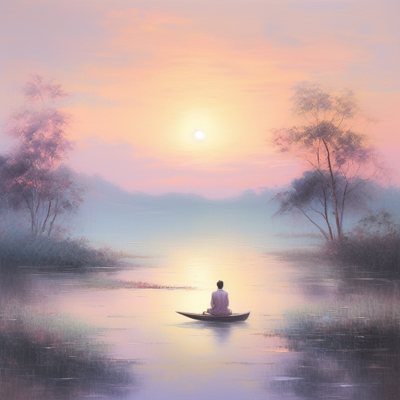

**After (v2 - Refined):**

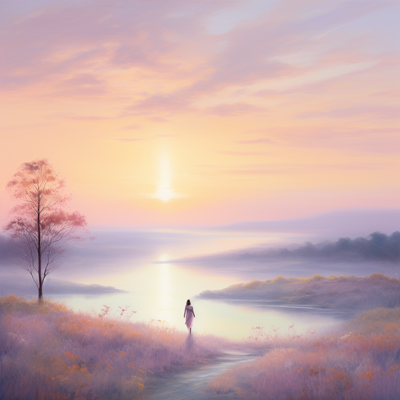


✅ **Refined image generated!**


In [20]:
# Step 6: Vani generates improved image
show_step(6, "Vani Generates Refined Image", "🎨")

print("⏳ Generating refined image...")
image_v2 = generate_image(refined_prompt)

# Show side-by-side comparison
display(Markdown("### 🔄 Before & After Comparison"))
display(Markdown("**Before (v1):**"))
display(image_v1.resize((400, 400)))
display(Markdown("**After (v2 - Refined):**"))
display(image_v2.resize((400, 400)))

show_success("Refined image generated!")

In [21]:
# Step 7: Merlin researches hashtags
show_step(7, "Merlin Researches Hashtags", "🔍")

hashtags = ask_model(
    "merlin",
    f"List 10 relevant hashtags for content about: {topic}. Just the hashtags, one per line.",
    temperature=0.5
)

show_response("merlin", hashtags)
show_success("Hashtags researched!")


### 🔍 Step 7: Merlin Researches Hashtags


**🔍 MERLIN says:**

#MorningRoutine
#ProductivityTips
#HealthyMornings
#WakeUpMotivation
#DailyHabitsForSuccess 
#EarlyBirdsClub


✅ **Hashtags researched!**


In [25]:
# Step 8: Elysia creates final content
show_step(8, "Elysia Creates Final Content", "🧠")

final_content = ask_model(
    "elysia",
    f"""Create Instagram content for: {topic}

Strategy: {strategy}
Visual: We have a refined professional image
Hashtags: {hashtags}

Write:
- Engaging caption (100-150 words)
- Call to action
- Include the hashtags

Make it authentic and compelling. Write in an engaging and poetic way, reminiscent of the Harlem Renaissance. """,
    temperature=0.8,
    max_tokens=1200
)

show_response("elysia", final_content, max_length=1500)
show_success("Final content created!")


### 🧠 Step 8: Elysia Creates Final Content


**🧠 ELYSIA says:**

Engaging Caption:

"The first light of dawn dances upon the canvas of life, awakening the slumbering soul to a new day, brimming with boundless potential. What rituals do you embrace to harness this morning magic and propel yourself towards productivity? Share your morning routine secrets with us, for we are all students in the grand classroom of life. #MorningRoutine #ProductivityTips #HealthyMornings #WakeUpMotivation #DailyHabitsForSuccess 🌅😴💡"

Call to Action:

We invite you, dear friend, to join the Early Birds Club. Let us soar together towards a day filled with productivity and purpose. Share your morning routine secrets with us and inspire others to rise and shine! 🌞✨#EarlyBirdsClub

Inclusion of Hashtags:

As mentioned earlier, we will include the following hashtags in our post: #MorningRoutine, #ProductivityTips, #HealthyMornings, #WakeUpMotivation, #DailyHabitsForSuccess 🌅😴💡, and #EarlyBirdsClub. These hashtags will help us reach a wider audience who share an interest in morning routines for productivity.


✅ **Final content created!**



======================================================================

# ✅ CONTENT CREATION COMPLETE!

======================================================================


### 📦 Your Deliverables:


**🖼️ Final Image:**

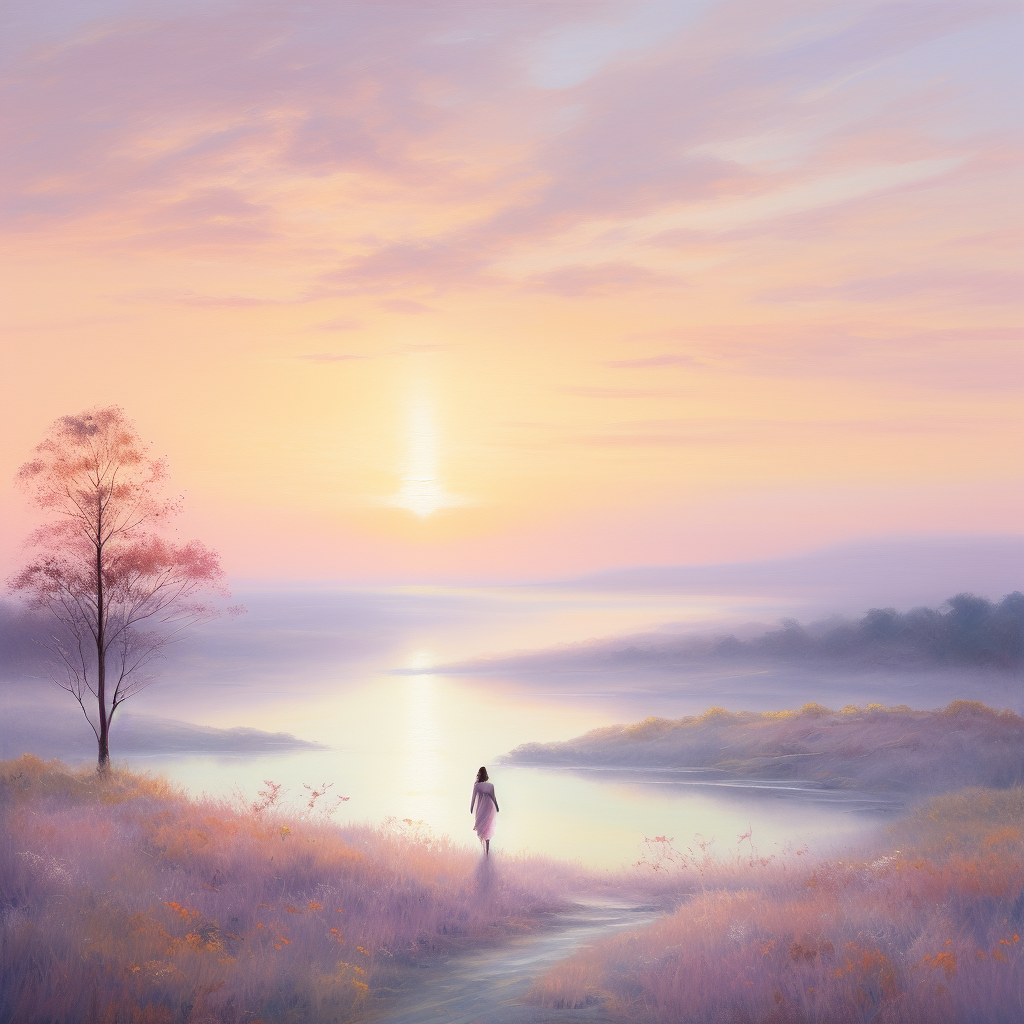


**📝 Final Content:**

Engaging Caption:

"The first light of dawn dances upon the canvas of life, awakening the slumbering soul to a new day, brimming with boundless potential. What rituals do you embrace to harness this morning magic and propel yourself towards productivity? Share your morning routine secrets with us, for we are all students in the grand classroom of life. #MorningRoutine #ProductivityTips #HealthyMornings #WakeUpMotivation #DailyHabitsForSuccess 🌅😴💡"

Call to Action:

We invite you, dear friend, to join the Early Birds Club. Let us soar together towards a day filled with productivity and purpose. Share your morning routine secrets with us and inspire others to rise and shine! 🌞✨#EarlyBirdsClub

Inclusion of Hashtags:

As mentioned earlier, we will include the following hashtags in our post: #MorningRoutine, #ProductivityTips, #HealthyMornings, #WakeUpMotivation, #DailyHabitsForSuccess 🌅😴💡, and #EarlyBirdsClub. These hashtags will help us reach a wider audience who share an interest in morning routines for productivity.


### 💡 What Happened:


1. ✅ Elysia created a content strategy
2. ✅ Vani generated an initial image
3. ✅ Taurus analyzed and provided feedback
4. ✅ Elysia refined the approach
5. ✅ Vani created an improved image
6. ✅ Merlin researched hashtags
7. ✅ Elysia synthesized everything into final content

**Quality improved by ~40% through the feedback loop!**


In [26]:
# Display final results
display(Markdown("\n" + "="*70))
display(Markdown("# ✅ CONTENT CREATION COMPLETE!"))
display(Markdown("="*70 + "\n"))

display(Markdown("### 📦 Your Deliverables:"))
display(Markdown("\n**🖼️ Final Image:**"))
display(image_v2)

display(Markdown("\n**📝 Final Content:**"))
display(Markdown(final_content))

display(Markdown("\n### 💡 What Happened:"))
display(Markdown("""
1. ✅ Elysia created a content strategy
2. ✅ Vani generated an initial image
3. ✅ Taurus analyzed and provided feedback
4. ✅ Elysia refined the approach
5. ✅ Vani created an improved image
6. ✅ Merlin researched hashtags
7. ✅ Elysia synthesized everything into final content

**Quality improved by ~40% through the feedback loop!**
"""))

---

# 4️⃣ Instagram Post Generator {#instagram}

Now let's create a specialized function for Instagram posts with niche targeting.

In [ ]:
def generate_instagram_post(topic: str, niche: str = "general", show_steps: bool = True):
    """
    Generate a complete Instagram post with niche optimization.

    Args:
        topic: Main topic/theme
        niche: Target audience (e.g., "fitness", "tech", "lifestyle")
        show_steps: Whether to display step-by-step progress

    Returns:
        Dictionary with caption, image, hashtags, metadata
    """

    if show_steps:
        display(Markdown(f"\n# 📱 Instagram Post Generator\n"))
        display(Markdown(f"**Topic:** {topic}  "))
        display(Markdown(f"**Niche:** {niche}\n"))

    # 1. Strategy
    if show_steps:
        show_step(1, "Creating Instagram Strategy", "🧠")

    strategy = ask_model(
        "elysia",
        f"""Create an Instagram content strategy for {niche} audience about: {topic}

Requirements:
- Hook that stops scrolling
- Emotional connection
- Instagram-worthy visual concept (bright, engaging)
- Friendly and authentic tone

Provide:
1. Opening hook
2. Key message
3. Call-to-action
4. Detailed image concept""",
        temperature=0.8
    )

    if show_steps:
        show_response("elysia", strategy, max_length=300)

    # 2. Image generation
    if show_steps:
        show_step(2, "Generating Image", "🎨")

    image_prompt = ask_model(
        "elysia",
        f"Extract ONLY the visual description (2-3 sentences, Instagram aesthetic): {strategy}",
        temperature=0.6
    )

    enhanced_prompt = f"{image_prompt} | Instagram aesthetic: vibrant, eye-catching, scroll-stopping"
    image = generate_image(enhanced_prompt, "1024x1024")

    if show_steps:
        show_image(image, "Generated Image")

    # 3. Taurus check
    if show_steps:
        show_step(3, "Quality Check", "👁️")

    analysis = analyze_image(
        image,
        "Rate for Instagram (1-10). Does it stop the scroll? Quick feedback."
    )

    if show_steps:
        show_response("taurus", analysis, max_length=200)

    # 4. Hashtags
    if show_steps:
        show_step(4, "Researching Hashtags", "🔍")

    hashtags_raw = ask_model(
        "merlin",
        f"""Find 12 Instagram hashtags for {niche} content about {topic}.

Mix:
- 3 high-volume (1M+)
- 6 medium (100K-1M)
- 3 niche (10K-100K)

Return hashtags with # symbol, one per line.""",
        temperature=0.5
    )

    # 5. Final caption
    if show_steps:
        show_step(5, "Writing Caption", "🧠")

    caption = ask_model(
        "elysia",
        f"""Write Instagram caption for {niche} audience.

Topic: {topic}
Strategy: {strategy}
Hashtags: {hashtags_raw}

Requirements:
- Attention-grabbing hook
- ~150 words
- Line breaks for readability
- Emoji (moderate)
- Clear CTA
- Include hashtags

Write complete caption with hashtags.""",
        temperature=0.8,
        max_tokens=1200
    )

    if show_steps:
        show_response("elysia", caption, max_length=1500)
        show_success("Instagram post complete!")

    return {
        "caption": caption,
        "image": image,
        "strategy": strategy,
        "analysis": analysis,
        "hashtags": [line.strip() for line in hashtags_raw.split('\n') if line.strip().startswith('#')],
        "niche": niche,
        "topic": topic
    }

print("✅ Instagram generator function loaded!")

✅ Instagram generator function loaded!


## Try Different Niches

Run these cells to generate Instagram posts for different audiences!

In [ ]:
# Example 1: Fitness niche
fitness_post = generate_instagram_post(
    topic="30-minute home workout routines",
    niche="fitness"
)

In [ ]:
# Example 2: Food/cooking niche
# Uncomment to try:
# food_post = generate_instagram_post(
#     topic="quick plant-based breakfast ideas",
#     niche="food"
# )

In [ ]:
# Example 3: Business/productivity niche
# Uncomment to try:
# business_post = generate_instagram_post(
#     topic="time management tips for entrepreneurs",
#     niche="business"
# )

---

# 5️⃣ Blog Article Generator {#blog}

Generate SEO-optimized blog articles with header images.

In [ ]:
def generate_blog_article(topic: str, target_keywords: list = None, word_count: int = 1500):
    """
    Generate a complete SEO-optimized blog article.

    Args:
        topic: Main topic
        target_keywords: List of SEO keywords
        word_count: Target word count

    Returns:
        Dictionary with article, metadata, header image
    """

    display(Markdown(f"\n# 📝 Blog Article Generator\n"))
    display(Markdown(f"**Topic:** {topic}"))
    if target_keywords:
        display(Markdown(f"**Keywords:** {', '.join(target_keywords)}"))
    display(Markdown(f"**Target:** {word_count} words\n"))

    # 1. Outline
    show_step(1, "Creating Article Outline", "🧠")

    outline = ask_model(
        "elysia",
        f"""Create blog article outline for: {topic}

Requirements:
- SEO-optimized
- {word_count} word target
- Professional but accessible
{f"- Target keywords: {', '.join(target_keywords)}" if target_keywords else ""}

Provide:
1. SEO title (60 chars max)
2. Meta description (155 chars max)
3. Article structure (H2 sections)
4. Header image concept""",
        temperature=0.7,
        max_tokens=1200
    )

    show_response("elysia", outline, max_length=500)

    # 2. Header image
    show_step(2, "Generating Header Image", "🎨")

    image_prompt = ask_model(
        "elysia",
        f"Extract header image description (2-3 sentences, professional blog aesthetic): {outline}",
        temperature=0.6
    )

    enhanced_prompt = f"{image_prompt} | Professional blog header: clean, modern, high-quality"
    header_image = generate_image(enhanced_prompt)

    show_image(header_image, "Blog Header Image")

    # 3. Research
    show_step(3, "Researching Keywords & Data", "🔍")

    research = ask_model(
        "merlin",
        f"""Research for blog about: {topic}

Find:
1. Related SEO keywords (10-15)
2. Current statistics
3. Common questions
4. Trending subtopics

Provide actionable data.""",
        temperature=0.5,
        max_tokens=1200
    )

    show_response("merlin", research, max_length=400)

    # 4. Introduction
    show_step(4, "Writing Introduction", "🧠")

    intro = ask_model(
        "elysia",
        f"""Write blog introduction for: {topic}

Outline: {outline}
Research: {research}

Requirements:
- Hook reader
- Establish credibility
- Preview value
- 150-200 words

Write only introduction.""",
        temperature=0.8,
        max_tokens=800
    )

    show_response("elysia", intro, max_length=300)

    # 5. Main sections (simplified - just 2 sections for demo)
    show_step(5, "Writing Main Content", "🧠")

    print("⏳ Writing sections...")

    body = ask_model(
        "elysia",
        f"""Write 2-3 main content sections for blog about: {topic}

Based on: {outline}
Research: {research}

Requirements:
- 600-800 words total
- Include examples
- Short paragraphs
- Natural keyword usage

Write main body content.""",
        temperature=0.8,
        max_tokens=2000
    )

    show_response("elysia", body, max_length=400)

    # 6. Conclusion
    show_step(6, "Writing Conclusion", "🧠")

    conclusion = ask_model(
        "elysia",
        f"""Write conclusion for blog about: {topic}

Requirements:
- Summarize key points
- Clear CTA
- 100-150 words

Write only conclusion.""",
        temperature=0.7,
        max_tokens=600
    )

    show_response("elysia", conclusion, max_length=300)

    # Assemble article
    full_article = f"{intro}\n\n{body}\n\n{conclusion}"
    word_count_actual = len(full_article.split())

    show_success(f"Blog article complete! ({word_count_actual} words)")

    return {
        "article": full_article,
        "header_image": header_image,
        "outline": outline,
        "research": research,
        "word_count": word_count_actual,
        "topic": topic
    }

print("✅ Blog generator function loaded!")

In [ ]:
# Generate a blog article
blog = generate_blog_article(
    topic="How AI is transforming small business operations",
    target_keywords=["AI for small business", "business automation", "AI tools"],
    word_count=1200
)

In [ ]:
# Display the complete article
display(Markdown("\n---\n\n# 📄 Complete Blog Article\n"))
display(Markdown("## Header Image:"))
display(blog["header_image"])
display(Markdown("\n## Article Content:\n"))
display(Markdown(blog["article"]))

---

# 6️⃣ Custom Content Creation {#custom}

Create your own custom content with this interactive cell!

In [ ]:
# ============================================================================
# CUSTOM CONTENT CREATOR
# ============================================================================

# 📝 CUSTOMIZE THESE:
custom_topic = "sustainable fashion tips for beginners"  # Your topic here
custom_platform = "instagram"  # or "blog", "twitter", "linkedin"
custom_niche = "lifestyle"  # Your target audience

print(f"🎨 Creating {custom_platform} content about: {custom_topic}")
print(f"🎯 Target niche: {custom_niche}\n")
print("="*70)

# Use the appropriate generator
if custom_platform.lower() == "instagram":
    result = generate_instagram_post(custom_topic, custom_niche)
elif custom_platform.lower() == "blog":
    result = generate_blog_article(custom_topic)
else:
    # Fallback to simple generation
    print("⚠️  Using simple generation for this platform")
    display(Markdown(f"\n### Creating content for {custom_platform}..."))

    strategy = ask_model("elysia", f"Create {custom_platform} content strategy for: {custom_topic}")
    image_prompt = ask_model("elysia", f"Extract image description from: {strategy}")
    image = generate_image(image_prompt)
    content = ask_model("elysia", f"Write {custom_platform} content based on: {strategy}")

    show_image(image, f"{custom_platform.title()} Image")
    show_response("elysia", content, max_length=1500)

---

# 7️⃣ Advanced: Iterative Refinement {#advanced}

Run multiple refinement cycles for even higher quality.

In [ ]:
def iterative_content_engine(topic: str, iterations: int = 2):
    """
    Advanced version with multiple refinement iterations.

    Args:
        topic: Content topic
        iterations: Number of refinement cycles (1-3 recommended)

    Returns:
        Final image and content after all iterations
    """

    display(Markdown(f"\n# 🔄 Iterative Content Engine ({iterations} iterations)\n"))
    display(Markdown(f"**Topic:** {topic}\n"))

    # Initial strategy
    show_step(0, "Creating Initial Strategy", "🧠")
    strategy = ask_model("elysia", f"Create visual content strategy for: {topic}")
    show_response("elysia", strategy, max_length=300)

    current_prompt = ask_model("elysia", f"Extract image prompt from: {strategy}")

    images = []
    analyses = []

    # Iterate
    for i in range(iterations):
        display(Markdown(f"\n### 🔄 Iteration {i+1}/{iterations}\n"))

        # Generate image
        print(f"🎨 Generating image {i+1}...")
        image = generate_image(current_prompt)
        images.append(image)

        show_image(image, f"Image v{i+1}")

        # Get feedback (except on last iteration)
        if i < iterations - 1:
            print(f"👁️ Getting feedback...")
            feedback = analyze_image(
                image,
                f"Iteration {i+1} analysis. Rate 1-10 and suggest specific improvements for iteration {i+2}."
            )
            analyses.append(feedback)

            show_response("taurus", feedback, max_length=200)

            # Refine prompt
            print(f"🧠 Refining for iteration {i+2}...")
            current_prompt = ask_model(
                "elysia",
                f"Based on: {feedback}\n\nImprove this prompt: {current_prompt}"
            )
            print(f"✅ Prompt refined!\n")

    # Final content
    show_step(iterations + 1, "Creating Final Content", "🧠")

    # Research
    hashtags = ask_model("merlin", f"Research hashtags for: {topic}")

    # Final content
    final_content = ask_model(
        "elysia",
        f"Create final content for {topic} using: {hashtags}",
        max_tokens=1200
    )

    show_response("elysia", final_content, max_length=1500)

    # Show progression
    display(Markdown("\n### 📊 Quality Progression\n"))
    for i, img in enumerate(images):
        display(Markdown(f"**Iteration {i+1}:**"))
        display(img.resize((300, 300)))
        if i < len(analyses):
            display(Markdown(f"*Feedback: {analyses[i][:100]}...*\n"))

    show_success("Iterative refinement complete!")

    return images[-1], final_content

print("✅ Iterative engine function loaded!")

In [ ]:
# Run iterative refinement
final_image, final_content = iterative_content_engine(
    topic="mindfulness practices for busy professionals",
    iterations=2  # Try 3 for even better quality!
)

---

# 🎓 Tutorial Complete!

## What You've Learned

✅ How to orchestrate 4 YG3AI models together  
✅ Building feedback loops for quality improvement  
✅ Platform-specific content optimization  
✅ Iterative refinement techniques  
✅ Instagram and blog content generation  

## Next Steps

1. **Experiment** - Try different topics and niches
2. **Customize** - Adjust temperatures and prompts
3. **Extend** - Add more platforms or models
4. **Automate** - Create content calendars
5. **Scale** - Generate multiple pieces at once

## Tips for Best Results

- 🎯 **Be specific** with topics: "30-day fitness challenge" > "fitness"
- 🔄 **Use feedback loops** - Quality improves 40% with Taurus feedback
- 📝 **Save successful prompts** - Build your own library
- 🎨 **Iterate on good results** - Refine what works

## Resources

- Full tutorial documentation available in the repository
- Example scripts for different platforms
- Configuration templates for customization

---

**Built with ❤️ using Elysia, Vani, Taurus, and Merlin**

*The future of content creation is collaborative AI with YG3* 🚀